In [ ]:
# importa e instala o SimPEG - Célula exclusiva para execução em ambiente remoto

# baseado no exemplo em https://docs.simpeg.xyz/content/tutorials/03-gravity/plot_1a_gravity_anomaly.html#sphx-glr-content-tutorials-03-gravity-plot-1a-gravity-anomaly-py

!git clone https://github.com/simpeg/simpeg
%cd simpeg
!pip install -r requirements.txt
!python setup.py install

import numpy as np
from scipy.interpolate import LinearNDInterpolator
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from discretize import TensorMesh
from discretize.utils import mkvc

from SimPEG.utils import plot2Ddata, model_builder, surface2ind_topo
from SimPEG import maps
from SimPEG.potential_fields import gravity

### Defining Topography
Surface topography is defined as an (N, 3) numpy array. We create it here but the topography could also be loaded from a file.

In [10]:
def config_espaco(x_lims, nx, y_lims, ny, z=None):
    """
    Define a topografia do modelo.
    x_lims: array com as distâncias mínima e máxima na direção X
    y_lims: array com as distâncias mínima e máxima na direção Y
    z: array com os valores de elevação e de tamanho (ny, nx)
    """

    [x_topo, y_topo] = np.meshgrid(np.linspace(x_lims[0], x_lims[1], nx), \
                       np.linspace(y_lims[0], y_lims[1], ny))
    
    if z=='default':
        z_topo = -15.0 * np.exp(-(x_topo ** 2 + y_topo ** 2) / 80 ** 2)
    
    elif not z:
        z_topo = np.zeros((ny, nx))

    x_topo = mkvc(x_topo)
    y_topo = mkvc(y_topo)
    z_topo = mkvc(z_topo)

    xyz_topo = np.c_[x_topo, y_topo, z_topo]

    return xyz_topo


In [11]:
mod_space = config_espaco((-200, 200), 41, (-200, 200), 41, z='default')

In [17]:
def config_aquisicao(x_lims, nx, y_lims, ny):
    
    """
    Define os pontos do levantamento
    """
    
    coord_x = np.linspace(x_lims[0], x_lims[1], nx)
    coord_y = np.linspace(y_lims[0], y_lims[1], ny)
    x, y = np.meshgrid(coord_x, coord_y)

    x = mkvc(x.T)
    y = mkvc(y.T)

    # cria a função de interpolação para o espaço do modelo
    fun_interp = LinearNDInterpolator(np.c_[mod_space[:, 0], mod_space[:, 1]], mod_space[:, 2])

    # interpola as coordenadas das estações e coloca 5.0 m acima da superfície
    z = fun_interp(np.c_[x, y])

    receiver_locations = np.c_[x, y, z]

    return receiver_locations

## Define the observation locations as an (N, 3) numpy array or load them.
#x = np.linspace(-80.0, 80.0, 17)
#y = np.linspace(-80.0, 80.0, 17)
#x, y = np.meshgrid(x, y)
#x, y = mkvc(x.T), mkvc(y.T)
#fun_interp = LinearNDInterpolator(np.c_[mod_space[:, 0], mod_space[:, 1]], mod_space[:, 2])
#z = fun_interp(np.c_[x, y]) + 5.0
#receiver_locations = np.c_[x, y, z]

        
    # Define the component(s) of the field we want to simulate as strings within
    # a list. Here we simulate only the vertical component of gravity anomaly.
    components = ['gx', 'gy', 'gz']

    # Use the observation locations and components to define the receivers. To
    # simulate data, the receivers must be defined as a list.
    receiver_list = gravity.receivers.Point(receiver_locations, components=components)

    receiver_list = [receiver_list]

    # Defining the source field.
    source_field = gravity.sources.SourceField(receiver_list=receiver_list)

    # Defining the survey
    survey = gravity.survey.Survey(source_field)    # é um objeto

    return survey

In [47]:
# Defining a Tensor Mesh
# Here, we create the tensor mesh that will be used to predict gravity anomaly data.
hx = [(5, 5, -1.3), (5, 40), (5, 5, 1.3)]
hy = [(5, 5, -1.3), (5, 40), (5, 5, 1.3)]
hz = [(5, 5, -1.3), (5, 15)]
mesh = TensorMesh([hx, hy, hz], "CCN")

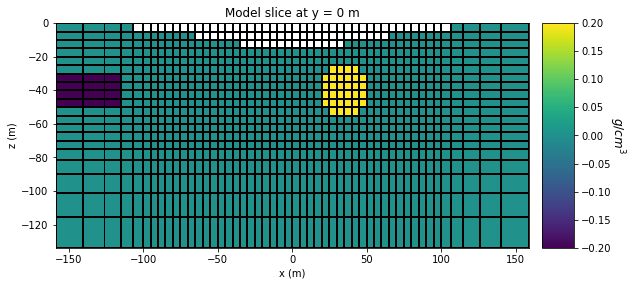

In [48]:
# Define density contrast values for each unit in g/cc
background_density = 0.0
block_density = -0.2
sphere_density = 0.2

# Find the indices for the active mesh cells (e.g. cells below surface)
ind_active = surface2ind_topo(mesh, mod_space)

# Define mapping from model to active cells. The model consists of a value for
# each cell below the Earth's surface.
nC = int(ind_active.sum())
model_map = maps.IdentityMap(nP=nC)

# Define model. Models in SimPEG are vector arrays.
model = background_density * np.ones(nC)

# You could find the indicies of specific cells within the model and change their
# value to add structures.
ind_block = (
    (mesh.gridCC[ind_active, 0] > -150.0)      # xi
    & (mesh.gridCC[ind_active, 0] < -120.0)    # xf
    & (mesh.gridCC[ind_active, 1] > -15.0)    # yi
    & (mesh.gridCC[ind_active, 1] < 15.0)     # yf
    & (mesh.gridCC[ind_active, 2] > -50.0)    # zi
    & (mesh.gridCC[ind_active, 2] < -30.0)    # zf
)
model[ind_block] = block_density

# You can also use SimPEG utilities to add structures to the model more concisely
ind_sphere = model_builder.getIndicesSphere(np.r_[35.0, 0.0, -40.0], 15.0, mesh.gridCC)
ind_sphere = ind_sphere[ind_active]
model[ind_sphere] = sphere_density

# Plot Density Contrast Model
fig = plt.figure(figsize=(9, 4))
plotting_map = maps.InjectActiveCells(mesh, ind_active, np.nan)

ax1 = fig.add_axes([0.1, 0.12, 0.73, 0.78])
mesh.plotSlice(
    plotting_map * model,
    normal="Y",
    ax=ax1,
    ind=int(mesh.nCy / 2),
    grid=True,
    clim=(np.min(model), np.max(model)),
    pcolorOpts={"cmap": "viridis"},
)
ax1.set_title("Model slice at y = 0 m")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.85, 0.12, 0.05, 0.78])
norm = mpl.colors.Normalize(vmin=np.min(model), vmax=np.max(model))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.viridis
)
cbar.set_label("$g/cm^3$", rotation=270, labelpad=15, size=12)

plt.show()

ValueError: ignored

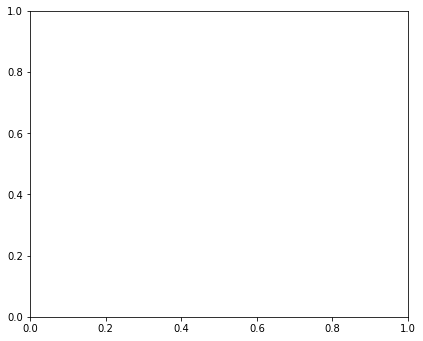

In [15]:
# Define the forward simulation. By setting the 'store_sensitivities' keyword
# argument to "forward_only", we simulate the data without storing the sensitivities
simulation = gravity.simulation.Simulation3DIntegral(
    survey=survey,
    mesh=mesh,
    rhoMap=model_map,
    actInd=ind_active,
    store_sensitivities="forward_only",
)

# Compute predicted data for some model
dpred = simulation.dpred(model)

# Plot
fig = plt.figure(figsize=(7, 5))

ax1 = fig.add_axes([0.1, 0.1, 0.75, 0.85])
plot2Ddata(receiver_list[0].locations, dpred, ax=ax1, contourOpts={"cmap": "bwr"})
ax1.set_title("Gravity Anomaly (Z-component)")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("y (m)")

ax2 = fig.add_axes([0.82, 0.1, 0.03, 0.85])
norm = mpl.colors.Normalize(vmin=-np.max(np.abs(dpred)), vmax=np.max(np.abs(dpred)))
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.bwr, format="%.1e"
)
cbar.set_label("$mgal$", rotation=270, labelpad=15, size=12)

plt.show()